In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install 'shimmy>=0.2.1'
!pip install git+https://github.com/DLR-RM/stable-baselines3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 37.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/DLR-RM/stable-baselines3 to /tmp/pip-req-build-3ztf0tf3
  Running command git clone --filter=blob:none --quiet https://github.com/DLR-RM/stable-baselines3 /tmp/pip-req-build-3ztf0tf3
  Resolved https://github.com/DLR-RM/stable-baselines3 to commit fd0cd82339511b54cd3907df228a656f2a32f0b8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for stable-baselines3: filename=stable_baselines3-2.0.0a8-py3-none-any.whl size=177948 sha256=a30ebdbf313c5f34c4e236bd6f63051b96107ef5f7db1b90e90e965c0f099d9f
  Stored in directory: /tmp/pip-ephem-wheel-cache-y7kx77i2/wheels/3b/24/65/bc2794face336930a7

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import torch
from gym.utils import seeding
import gym
from gym import spaces
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO, DDPG
import ast

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


# 0. Load data

In [ ]:
# set directory
ROOT_PATH = '/content/drive/MyDrive/MBAn/Sensorimotor/project'
directory = ROOT_PATH + '/data/'
model_dir = ROOT_PATH + '/model/'
result_dir = ROOT_PATH + '/result/'

# set global variable TOKENS used in all environments
TOKENS = ['ADA', 'ATOM', 'AVAX', 'BNB', 'BTC', 'DOGE', 'DOT', 'ETH', 'LINK', 'LTC', 'MATIC', 'SHIB', 'SOL', 'TRX', 'UNI', 'XRP']

In [ ]:
df_close = pd.read_csv(directory+'df_close.csv')
df_close.open_time_ms = pd.to_datetime(df_close['open_time_ms'])
df_close.head()

,open_time_ms,ADA_close,ATOM_close,AVAX_close,BNB_close,BTC_close,DOGE_close,DOT_close,ETH_close,LINK_close,LTC_close,MATIC_close,SHIB_close,SOL_close,TRX_close,UNI_close,XRP_close,USD_close
0,2022-01-01 00:00:00,1.314,32.81,109.98,512.9,46321.34,0.1705,26.75,3690.09,19.57,146.4,2.541,0.000033,170.40,0.07552,17.08,0.8334,1.0
1,2022-01-01 00:05:00,1.316,32.58,110.06,513.3,46371.11,0.1703,26.80,3696.55,19.58,146.6,2.545,0.000033,170.60,0.07538,17.09,0.8330,1.0
2,2022-01-01 00:10:00,1.317,32.46,110.07,513.5,46332.51,0.1705,26.84,3691.90,19.60,146.7,2.546,0.000033,170.85,0.07538,17.11,0.8322,1.0
3,2022-01-01 00:15:00,1.317,32.47,109.95,513.5,46293.90,0.1703,26.77,3689.51,19.57,146.6,2.536,0.000033,171.07,0.07531,17.08,0.8319,1.0
4,2022-01-01 00:20:00,1.322,32.77,110.61,514.3,46395.53,0.1709,26.95,3699.45,19.64,147.0,2.548,0.000034,171.20,0.07553,17.10,0.8349,1.0


In [ ]:
df_volume = pd.read_csv(directory+'df_volume.csv')
df_volume.open_time_ms = pd.to_datetime(df_volume['open_time_ms'])
df_volume.head()

,open_time_ms,ADA_volume,ATOM_volume,AVAX_volume,BNB_volume,BTC_volume,DOGE_volume,DOT_volume,ETH_volume,LINK_volume,LTC_volume,MATIC_volume,SHIB_volume,SOL_volume,TRX_volume,UNI_volume,XRP_volume,USD_volume
0,2022-01-01 00:00:00,1209224.3,54621.76,8587.78,2352.644,185.67558,2519628.0,24592.11,1363.4570,33197.32,2050.067,449849.2,2.162479e+10,4329.30,3076457.5,6739.54,945000.0,0.0
1,2022-01-01 00:05:00,298386.5,28489.13,7392.95,1688.173,123.43577,1783685.0,17049.93,862.5494,13470.81,655.730,203782.8,1.347277e+10,2212.70,2180233.5,4115.82,468801.0,0.0
2,2022-01-01 00:10:00,389329.2,20890.84,5129.06,1023.833,77.54574,1428416.0,12995.91,753.5524,10046.50,544.532,181298.2,1.042813e+10,3310.82,1649554.4,7447.60,631674.0,0.0
3,2022-01-01 00:15:00,221077.2,9810.92,7974.74,1377.344,101.14315,1148033.0,9857.93,438.4134,7221.73,416.076,141379.4,2.456715e+10,2917.19,1038627.4,10391.02,346621.0,0.0
4,2022-01-01 00:20:00,189448.2,7518.41,4352.98,1304.058,135.32479,894261.0,33604.41,372.5966,6060.02,971.667,153877.3,6.909299e+09,2954.40,909110.0,4209.92,546138.0,0.0


In [ ]:
timeline = df_volume.open_time_ms
btc_benchmark = df_close.BTC_close
eth_benchmark = df_close.ETH_close

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
px = df_close.iloc[:,1:].values

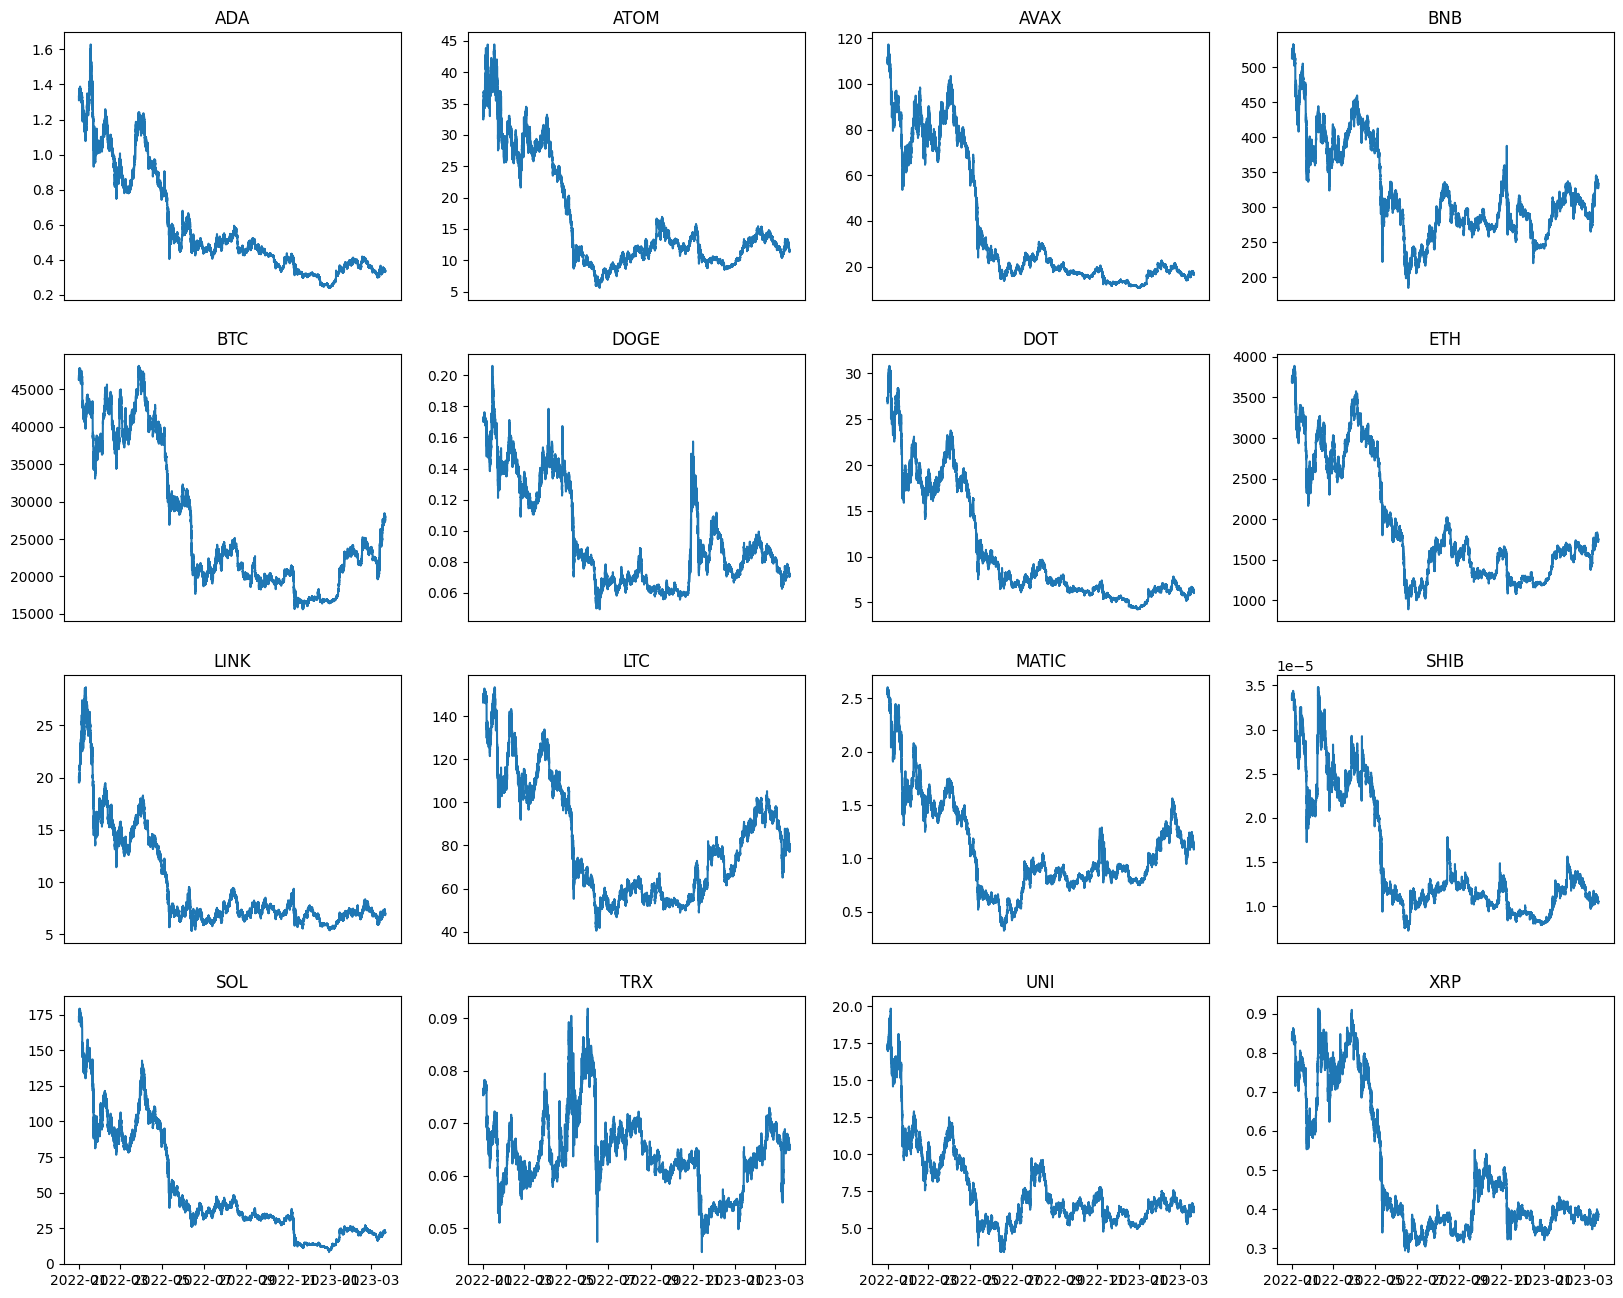

In [ ]:
fig, ax = plt.subplots(4,4,figsize=(20,16))

for i in range(16):
    ax[i//4][i%4].plot(timeline, px[:,i])
    ax[i//4][i%4].set_title(TOKENS[i])
    
    if i < 12:
        ax[i//4][i%4].get_xaxis().set_ticks([])

# 2. Long & short, technicals in state space

## Environment
- added shorting (half in long and half in short, p&l each period = weights * % change in price)
- removed USD as if the strategy is market neural we should be able to fully deploy at all times (starting with 0 weights in all)
- added randomize start time: idea is that we pick a random point in time to start, we run for `total_time` steps. Allows for more episodes and might encourage data diversity.

In [ ]:
class LongShortEnv(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim=16,
                initial_amount=1e4,
                state_space=22,
                action_space=16,
                lookback=13,
                max_timesteps=1e4,
                random_init_t=True,
                transaction_cost_pct=0,                                               # Incorporate transaction cost by setting a value between 0 and 1
                mode='train'):

        # Initialise parameters
        self.t = 0                                                                    # Initialise initial timestep, t, to be 0
        self.max_timesteps = max_timesteps                                            # Maximum number of timesteps per episode/trajectory
        self.lookback = lookback
        self.df = df
        self.last_timestep = self.df.shape[0]                                         # Specify last timestep
        self.stock_dim = stock_dim                                                    # 16 different assets
        self.initial_amount = initial_amount                                          # Initial investment amount
        self.state_space = state_space                                                # 22 features
        self.action_space = action_space                                              # 16 continuous actions (weights)
        self.current_episode = 0                                                      # Episode counter
        self.mode = mode                                                              # Mode = 'train' prints episodic items, mode = 'predict' doesn't
        self.transaction_cost_pct = transaction_cost_pct

        # Randomise starting timestep between 0 and (max_timesteps from the last_timestep)
        self.start_t = 0
        self.random_init_t = random_init_t
        if self.random_init_t:                              # If TRUE -> Randomise starting timestep
          if self.max_timesteps < self.last_timestep:
            self.start_t = np.random.randint(0, self.last_timestep - self.max_timesteps - 1)

        # Action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = -1, high = 1,shape = (self.action_space,))                                                              # The action space outputted should be a 1D 16-dimensional array (assuming 16 stocks)
        
        # State space shape = (16, 24)
        # We have 16 unique cryptocurrencies and 24 features
        # No time dimesnion, each observation space is representative of a given timestep
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.stock_dim, self.state_space))                                     # The observation space (14x action independent features, 2x action dependent features)

        # ------------------ Load data from a pandas dataframe -----------------------------
        ## Extracts the data for the current timestep (specified by self.t) from the input DataFrame self.df. This data includes close prices, % changes, and EMA
        self.data = self.df[self.start_t + self.t]

        ## Constructs the state array by combining the action independent features: closing price t, 12x percentage change in closing prices, EMA_t
        ## It appends the 14 action independent features with the 2 additional action dependent features along axis 0 (rows - the cryptocurrencies)
        ## The resulting self.state is a 2D array with the shape (16, 22), as discussed earlier
        self.state = self.data

        ## Initialise terminality. False at the beginning. Will be updated as we train
        self.terminal = False    
        
        # ------------------ Initialises the agent's portfolio value to the initial investment amount --------------------------------
        ## This portfolio value will be updated as we go along
        self.portfolio_value = self.initial_amount

        # Memorize portfolio value each step
        ## Initialises a list called `self.asset_memory` to store the agent's portfolio value at each time step. The list starts with the initial investment amount.
        self.asset_memory = [self.initial_amount]

        # Memorize portfolio return each step
        ## Initialises a list called `self.portfolio_return_memory` to store the agent's daily portfolio return at each time step. The list starts with 0, as there is no return on the first day.
        self.portfolio_return_memory = [0]

        ## Initialises a list called `self.actions_memory` to store the agent's actions (portfolio weights) at each time step. The list starts with equal weights for all stocks in the portfolio (i.e., 1 divided by the number of stocks).
        # self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.actions_memory = [[0] * self.stock_dim]                    # 16 crypto assets, 1 cash asset. Initialise by allocating all funds to the cash asset

        ## Initialises a list called self.date_memory to store each time step. The list starts with the timestep of the first data entry in the environment's data (self.data).
        self.timestep_memory = [self.start_t + self.t]

        
    def step(self, actions):
        ## Checks if the current t >= max_timesteps. If true, sets self.terminal to True, indicating the end of the episode.
        self.terminal = self.t >= self.max_timesteps - 1
        
        # ------------------ If end of episode (i.e., the last timestep, which is user specified) -----------------
        if self.terminal:

          cumulative_return = (self.portfolio_value / self.initial_amount) - 1

          if self.mode == 'train':
            print(f"Episode: {self.current_episode} | Timesteps: {self.t + 1} | Cumulative Return: {cumulative_return:.2%}")
            
          else:
            print('Done')

          ## Finally, it returns the current state, reward, and terminal status along with an empty dictionary.
          return self.state, self.reward, self.terminal, {}

        # ----------------- If the current timestep is not the last timestep ---------------------
        else:
            
            ## Normalize the input actions using softmax normalization, which ensures that the portfolio weights sum to 1.
            weights = self.longshort(torch.tensor(actions))

            ## Append the normalized weights to the actions memory.
            self.actions_memory.append(weights)

            ## Store the data for the current timestep before moving to the next timestep.
            prev_timestep_memory = self.data
            # prev_holdings = self.current_holdings

            # ------------------------ Next State ------------------------------
            ##  Increment the `time` counter to move to the next timestep.
            self.t += 1
            
            ## Update `self.data` and `self.state` to the new timestep's values
            ## Creating a new state with the new timestep action independent features and create new action dependent features
            self.data = self.df[self.start_t + self.t]

            # Calculate portfolio return
            ## Portfolio return (a scalar) based on the new timestep's closing prices and the portfolio weights (returns x weights)
            ## [close_price_t / close_price_(t-1)] - 1. If positive, then returns are profitable, otherwise loss
            ## NOTE: (self.data.close.values / prev_timestep_memory.close.values) - 1 : Calculates the percentage gain/loss for each crypto
            ## NOTE: Multiplying these percentage returns by their respective weights (*weights) gives the weighted return of each crypto
            ## NOTE: Then sum over all stocks to calculate the portfolio return for that timestep
            ## Column 0 = closing prices. Row index = cryptocurrencies
            portfolio_return = torch.sum(((self.data[:,0] / prev_timestep_memory[:,0]) - 1) * weights) - self.transaction_cost_pct

            # Update portfolio value
            ## Calculate the new portfolio value based on the calculated portfolio return from before
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)

            ## Update the portfolio value with the new value
            self.portfolio_value = new_portfolio_value

            # Save into memory: the new portfolio return, new date, and new portfolio value
            self.portfolio_return_memory.append(portfolio_return)
            self.timestep_memory.append(self.start_t + self.t)            
            self.asset_memory.append(new_portfolio_value)

            # The reward is the immediate reward at the current timestep not the cumulative returns (i.e., new_portfolio_value)
            self.reward = portfolio_return

        # Return the updated state, reward, terminal status, and an empty dictionary
        return self.state, self.reward, self.terminal, {}

    
    # The environment is reset to its initial state, which is necessary for the beginning of a new training episode or evaluation
    def reset(self):
        
        ## Resets the asset_memory to the initial amount (i.e., portfolio value)
        self.asset_memory = [self.initial_amount]

        ## Resets the timestep counter to 0 (the first timestep)
        self.t = 0

        # Randomise starting timestep between 0 and (max_timesteps from the last_timestep)
        self.start_t = 0
        if self.random_init_t:                              # If TRUE -> Randomise starting timestep
          if self.max_timesteps < self.last_timestep:
            self.start_t = np.random.randint(0, self.last_timestep - self.max_timesteps - 1)

        ## Increment episode number by 1
        self.current_episode += 1

        ## Retrieves the data for the first timestep from the dataframe
        self.data = self.df[self.start_t + self.t]

        ## Set the state = data
        self.state = self.data

        ## Resets the portfolio value to the initial amount
        self.portfolio_value = self.initial_amount

        ## Resets the terminal flag to False, indicating that the episode has not ended
        self.terminal = False 

        ## Resets the portfolio_return_memory to its initial state, with a 0% return (no return on the first timestep)
        self.portfolio_return_memory = [0]

        ## Resets the actions_memory with an initial equal-weighted portfolio
        self.actions_memory = [[0] * self.stock_dim]                    # 16 crypto assets

        ## Resets the timestep_memory with the first timestep
        self.timestep_memory = [self.start_t + self.t]

        # Initial state is returned 
        return self.state
    
    def render(self, mode='human'):
        return self.state

    def longshort(self, actions):
        eps = 1e-10

        ## If actions is not a tensor, then make into a tensor
        if not isinstance(actions, torch.Tensor):
            actions = torch.tensor(actions)
        
        ## Standardise around the mean
        actions = actions - actions.mean()

        ## If sum of absolute values is 0, then introduce a small offset = eps
        if actions.abs().sum() < eps:
            actions = actions / (actions.abs().sum()+eps)
        
        ## Otherwise, no offset
        else:
            actions = actions / actions.abs().sum()

        return actions

    # Saves the date and daily return of the portfolio into a DataFrame and return this DataFrame
    def save_asset_memory(self):
        return self.asset_memory

    def save_action_memory(self):

        ## Retrieves the date_memory list (all dates in an episode)
        timestep_list = self.timestep_memory

        ## Creates a DataFrame using the list of dates in an episode and labels the column as 'date'
        ## Basically a DataFrame with 1 column = 'date'
        df_timestep = pd.DataFrame(timestep_list)
        df_timestep.columns = ['timestep']
        
        ## Retrieves the list of actions (i.e., a list of 17 weights for a given time step) taken at each time step of an episode
        ## Hence, our action_list is basically n_timesteps x [a list of 17 weights] (i.e., n_timestep lists)
        action_list = self.actions_memory

        ## Creates a DataFrame using the list of actions with column names set as the stock ticker symbols (AAPL, FB, GOOGL, etc.)
        ## The dimension of df_actions is (n_dates, n_stocks), where n_dates is the number of timesteps in any episode (should be constant) and n_stocks is the number of stocks in the portfolio
        ## Each row in `df_actions` corresponds to a given date, and the value in a given row will be the portfolio weights of each stock (basically unpacked the list inside the list)
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = ['ADA', 'ATOM', 'AVAX', 'BNB', 'BTC', 'DOGE', 'DOT', 'ETH', 'LINK', 'LTC', 'MATIC', 'SHIB', 'SOL', 'TRX', 'UNI', 'XRP']
        df_actions.index = df_timestep.timestep

        # Return the generated action DataFrame
        return df_actions

    # Sets the random seed for the environment
    ## If a seed value is passed, it uses that value, otherwise it generates a new random seed using seeding.np_random(seed)
    ## It returns a list containing the generated seed value.
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    # Helper function that returns a stable-baselines compatible vectorized environment (e) and the initial observation of the environment (obs)
    ## GOAL: To integrate the environment with Stable Baselines (basically translating our user defined environment to make it compatible with Stable Baselines)
    def get_sb_env(self):

        ## Creates a DummyVecEnv instance (e) with a lambda function that returns the environment itself. 
        e = DummyVecEnv([lambda: self])

        ## Calls the reset method of the DummyVecEnv to get the initial observation
        obs = e.reset()

        ## Returns the DummyVecEnv instance (e) and the initial observation
        return e, obs

## State Space

0. current price (normalize all cryptos)
1. 12 period EMA
2. Moving Average Convergence Divergence (MACD): EMA(26) - EMA(12)
3. 1 period returns
4. 2 period cumulative returns
5. 6 period cumulative returns
6. 12 period cumulative returns
7. 24 period cumulative returns
8. 1 period returns relative to market
9. 2 period cumulative returns relative to market
10. 6 period cumulative returns relative to market
11. 12 period cumulative returns relative to market
12. 24 period cumulative returns relative to market
13. 14 period RSI
14. 14 period RSI relative to market
15. 12 period volatility (stdev)
16. 24 period volatility (stdev)
17. 1 period volume (normalized)
18. 2 period volume
19. 6 period volume
20. 12 period volume
21. 24 period volume


In [ ]:
# MACD uses 26 periods so we start index from 25 onwards
start_idx = 25
n_peirods_total = len(df_close)-start_idx

In [ ]:
# state space shape: 16 cyrpto currencies (market neural so don't need cash), 22 features each
data = torch.zeros([n_peirods_total,16,22])

In [ ]:
# 0. current price, normalize all by dividing by the first datapoint
px = df_close.iloc[:,1:-1].values
px = px / px[0]
data[:,:,0] = torch.tensor(px[start_idx:])

In [ ]:
# 1. 12 period EMA

def ema(prices, n):
    smoothing_factor = 2 / (n + 1)
    ema_values = np.zeros_like(prices)
    ema_values[0,:] = prices[0,:]
    for i in range(1, prices.shape[0]):
        ema_values[i,:] = (prices[i,:] * smoothing_factor) + (ema_values[i-1,:] * (1 - smoothing_factor))
    return ema_values

ema_12 = ema(px,12)
data[:,:,1] = torch.tensor(ema_12[start_idx:])

In [ ]:
# 2. MACD

macd = ema(px,26) - ema_12
data[:,:,2] = torch.tensor(macd[start_idx:])

In [ ]:
# 3-7. 1,2,6,12,24 period returns

per = [1,2,6,12,24]

for i,t in enumerate(per):
    ret = (px[t:] - px[:-t]) / px[:-t]
    data[:,:,i+3] = torch.tensor(ret[ret.shape[0] - n_peirods_total:])

In [ ]:
# 8-12. 1,2,6,12,24 period returns relative to market

data[:,:,8:13] = data[:,:,3:8] - data[:,:,3:8].mean(dim=0)

In [ ]:
# 13-14. 14 period RSI / relative to market

def rsi(prices, n=14):
    deltas = prices[1:] - prices[:-1]
    seed = deltas[:n+1]
    up = (seed * (seed >= 0)).sum(axis=0) / n
    down = (-seed * (seed < 0)).sum(axis=0) / n
    rs = up / down
    rsi = np.zeros([prices.shape[0]-n,prices.shape[1]])
    rsi[0] = 1 - 1 / (1 + rs)

    for i in range(n+1, prices.shape[0]):
        delta = deltas[i-1]  # the delta for the current price
        up = (up * (n - 1) + (delta * (delta>=0))) / n
        down = (down * (n - 1) + (-delta* (delta<0))) / n
        rs = up / down
        rsi[i-n] = 1 - 1 / (1 + rs)

    return rsi

rsi_14 = rsi(px)
data[:,:,13] = torch.tensor(rsi_14[rsi_14.shape[0] - n_peirods_total:])

data[:,:,14] = data[:,:,13] - data[:,:,13].mean(dim=0)

In [ ]:
# 15-16. vol 12 & 24

def rolling_vol(prices, n):
    vol = np.zeros_like(prices)
    for i in range(n,prices.shape[0]):
        vol[i] = prices[i-n:i].std(axis=0)
    return vol

vol_12 = rolling_vol(px,12)
data[:,:,15] = torch.tensor(vol_12[start_idx:])

vol_24 = rolling_vol(px,24)
data[:,:,16] = torch.tensor(vol_24[start_idx:])

In [ ]:
# 17. 1 period volume

volume = df_volume.iloc[:,1:-1].values

# Normalize volume by average in the first 26 periods
# This is kind of arbitrary but thought it might run better with all the numbers close to 1
volume = volume / volume[0:26].mean(axis=0)

data[:,:,17] = torch.tensor(volume[start_idx:])

In [ ]:
# 18-21. 2,6,12,24 period volume

def sum_volume(volume, n):
    volume = np.zeros_like(volume)
    for i in range(n,volume.shape[0]):
        volume[i] = volume[i-n:i].sum(axis=0)
    return volume

per = [2,6,12,24]

for i,t in enumerate(per):
    vol_sum = sum_volume(volume,t)
    data[:,:,18+i] = torch.tensor(vol_sum[start_idx:])

### Split Train / Validation / Test

In [ ]:
val_idx = int(n_peirods_total*0.7)
test_idx = int(n_peirods_total*0.85)

train_data = data[:val_idx]
val_data = data[val_idx:test_idx]
test_data = data[test_idx:]

In [ ]:
timeline[0],timeline[val_idx],timeline[test_idx],timeline[len(timeline)-1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(Timestamp('2022-01-01 00:00:00'),
 Timestamp('2022-11-08 01:10:00'),
 Timestamp('2023-01-13 16:50:00'),
 Timestamp('2023-03-21 10:35:00'))

## Agents $\gamma=0.5$

In [ ]:
df_inSample = pd.DataFrame({'time':timeline[start_idx:val_idx+start_idx]})
df_val = pd.DataFrame({'time':timeline[val_idx+start_idx:test_idx+start_idx]})

### A2C

In [ ]:
ls_train_gym = LongShortEnv(full_data = train_data)

#### A2C - Load model

In [ ]:
a2c_model = A2C.load(model_dir + "A2C_05Gamma_v1")

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.
  warnings.warn(


#### A2C - in sample performance

In [ ]:
# in sample performance
ls_train_gym.mode = 'Val'
ls_train_gym.rand_start_time = False
ls_train_gym.total_time = train_data.shape[0]

obs = ls_train_gym.reset()

for i in range(train_data.shape[0]-1):
    action, _states = a2c_model.predict(obs)
    obs, rewards, dones, info = ls_train_gym.step(action)
port_size =ls_train_gym.save_asset_memory()
weights = ls_train_gym.save_action_memory()

df_inSample['A2C'] = port_size

#### A2C - Val

In [ ]:
# out of sample performance
ls_val_gym = LongShortEnv(full_data=val_data, total_time=val_data.shape[0], mode='Val', rand_start_time=False)

obs = ls_val_gym.reset()
for i in range(val_data.shape[0]-1):
    action, _states = a2c_model.predict(obs)
    obs, rewards, dones, info = ls_val_gym.step(action)
val_port_size =ls_val_gym.save_asset_memory()
val_weights = ls_val_gym.save_action_memory()

df_val['A2C'] = val_port_size

### PPO

#### PPO - Load model

In [ ]:
ls_train_gym = LongShortEnv(full_data = train_data)

In [ ]:
ppo_model = PPO.load(model_dir + "PPO_05Gamma_v1")

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.
  warnings.warn(


#### PPO - in sample

In [ ]:
# in sample performance
ls_train_gym.mode = 'Val'
ls_train_gym.rand_start_time = False
ls_train_gym.total_time = train_data.shape[0]

obs = ls_train_gym.reset()

for i in range(train_data.shape[0]-1):
    action, _states = ppo_model.predict(obs)
    obs, rewards, dones, info = ls_train_gym.step(action)
port_size =ls_train_gym.save_asset_memory()
weights = ls_train_gym.save_action_memory()

In [ ]:
df_inSample['PPO'] = port_size

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### PPO - Val

In [ ]:
# out of sample performance
ls_val_gym = LongShortEnv(full_data=val_data, total_time=val_data.shape[0], mode='Val', rand_start_time=False)

obs = ls_val_gym.reset()
for i in range(val_data.shape[0]-1):
    action, _states = ppo_model.predict(obs)
    obs, rewards, dones, info = ls_val_gym.step(action)
val_port_size =ls_val_gym.save_asset_memory()
val_weights = ls_val_gym.save_action_memory()

In [ ]:
df_val['PPO'] = val_port_size

### DDPG

#### DDPG - train

In [ ]:
ls_train_gym = LongShortEnv(full_data = train_data)

In [ ]:
ddpg_model = DDPG.load(model_dir + "DDPG_05Gamma_v1")

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.
  warnings.warn(


#### DDPG - in sample

In [ ]:
# in sample performance
ls_train_gym.mode = 'Val'
ls_train_gym.rand_start_time = False
ls_train_gym.total_time = train_data.shape[0]

obs = ls_train_gym.reset()

for i in range(train_data.shape[0]-1):
    action, _states = ddpg_model.predict(obs)
    obs, rewards, dones, info = ls_train_gym.step(action)
port_size =ls_train_gym.save_asset_memory()
weights = ls_train_gym.save_action_memory()

In [ ]:
df_inSample['DDPG'] = port_size

#### DDPG - Val

In [ ]:
# out of sample performance
ls_val_gym = LongShortEnv(full_data=val_data, total_time=val_data.shape[0], mode='Val', rand_start_time=False)

obs = ls_val_gym.reset()
for i in range(val_data.shape[0]-1):
    action, _states = ddpg_model.predict(obs)
    obs, rewards, dones, info = ls_val_gym.step(action)
val_port_size =ls_val_gym.save_asset_memory()
val_weights = ls_val_gym.save_action_memory()

In [ ]:
df_val['DDPG'] = val_port_size

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Agents $\gamma=0.99$

In [ ]:
df_inSample = pd.DataFrame({'time':timeline[start_idx:val_idx+start_idx]})
df_val = pd.DataFrame({'time':timeline[val_idx+start_idx:test_idx+start_idx]})

### A2C

In [ ]:
ls_train_gym = LongShortEnv(full_data = train_data)

#### A2C - Load model

In [ ]:
a2c_model = A2C.load(model_dir + "A2C_01Gamma_v1")

#### A2C - in sample performance

In [ ]:
# in sample performance
ls_train_gym.mode = 'Val'
ls_train_gym.rand_start_time = False
ls_train_gym.total_time = train_data.shape[0]

obs = ls_train_gym.reset()

for i in range(train_data.shape[0]-1):
    action, _states = a2c_model.predict(obs)
    obs, rewards, dones, info = ls_train_gym.step(action)
port_size =ls_train_gym.save_asset_memory()
weights = ls_train_gym.save_action_memory()

df_inSample['A2C_gamma=0.99'] = port_size

#### A2C - Val

In [ ]:
# out of sample performance
ls_val_gym = LongShortEnv(full_data=val_data, total_time=val_data.shape[0], mode='Val', rand_start_time=False)

obs = ls_val_gym.reset()
for i in range(val_data.shape[0]-1):
    action, _states = a2c_model.predict(obs)
    obs, rewards, dones, info = ls_val_gym.step(action)
val_port_size =ls_val_gym.save_asset_memory()
val_weights = ls_val_gym.save_action_memory()

df_val['A2C_gamma=0.99'] = val_port_size

### PPO

#### PPO - Load model

In [ ]:
ls_train_gym = LongShortEnv(full_data = train_data)

In [ ]:
ppo_model = PPO.load(model_dir + "Trader_Joe_PPO")

#### PPO - in sample

In [ ]:
# in sample performance
ls_train_gym.mode = 'Val'
ls_train_gym.rand_start_time = False
ls_train_gym.total_time = train_data.shape[0]

obs = ls_train_gym.reset()

for i in range(train_data.shape[0]-1):
    action, _states = ppo_model.predict(obs)
    obs, rewards, dones, info = ls_train_gym.step(action)
port_size =ls_train_gym.save_asset_memory()
weights = ls_train_gym.save_action_memory()

In [ ]:
df_inSample['PPO_gamma=0.99'] = port_size

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### PPO - Val

In [ ]:
# out of sample performance
ls_val_gym = LongShortEnv(full_data=val_data, total_time=val_data.shape[0], mode='Val', rand_start_time=False)

obs = ls_val_gym.reset()
for i in range(val_data.shape[0]-1):
    action, _states = ppo_model.predict(obs)
    obs, rewards, dones, info = ls_val_gym.step(action)
val_port_size =ls_val_gym.save_asset_memory()
val_weights = ls_val_gym.save_action_memory()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_val['PPO_gamma=0.99'] = val_port_size

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### DDPG

#### DDPG - train

In [ ]:
ls_train_gym = LongShortEnv(full_data = train_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
ddpg_model = DDPG.load(model_dir + "Trader_Joe_DDPG")

#### DDPG - in sample

In [ ]:
# in sample performance
ls_train_gym.mode = 'Val'
ls_train_gym.rand_start_time = False
ls_train_gym.total_time = train_data.shape[0]

obs = ls_train_gym.reset()

for i in range(train_data.shape[0]-1):
    action, _states = ddpg_model.predict(obs)
    obs, rewards, dones, info = ls_train_gym.step(action)
port_size =ls_train_gym.save_asset_memory()
weights = ls_train_gym.save_action_memory()

In [ ]:
df_inSample['DDPG_gamma=0.99'] = port_size

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### DDPG - Val

In [ ]:
# out of sample performance
ls_val_gym = LongShortEnv(full_data=val_data, total_time=val_data.shape[0], mode='Val', rand_start_time=False)

obs = ls_val_gym.reset()
for i in range(val_data.shape[0]-1):
    action, _states = ddpg_model.predict(obs)
    obs, rewards, dones, info = ls_val_gym.step(action)
val_port_size =ls_val_gym.save_asset_memory()
val_weights = ls_val_gym.save_action_memory()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_val['DDPG_gamma=0.99'] = val_port_size

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Agents $\gamma=0.1$

### A2C

In [ ]:
ls_train_gym = LongShortEnv(full_data = train_data)

#### A2C - Load model

In [ ]:
a2c_model = A2C.load(model_dir + "A2C_01Gamma_v1")

#### A2C - in sample performance

In [ ]:
# in sample performance
ls_train_gym.mode = 'Val'
ls_train_gym.rand_start_time = False
ls_train_gym.total_time = train_data.shape[0]

obs = ls_train_gym.reset()

for i in range(train_data.shape[0]-1):
    action, _states = a2c_model.predict(obs)
    obs, rewards, dones, info = ls_train_gym.step(action)
port_size =ls_train_gym.save_asset_memory()
weights = ls_train_gym.save_action_memory()

df_inSample['A2C_gamma=0.1'] = port_size

#### A2C - Val

In [ ]:
# out of sample performance
ls_val_gym = LongShortEnv(full_data=val_data, total_time=val_data.shape[0], mode='Val', rand_start_time=False)

obs = ls_val_gym.reset()
for i in range(val_data.shape[0]-1):
    action, _states = a2c_model.predict(obs)
    obs, rewards, dones, info = ls_val_gym.step(action)
val_port_size =ls_val_gym.save_asset_memory()
val_weights = ls_val_gym.save_action_memory()

df_val['A2C_gamma=0.1'] = val_port_size

### PPO

#### PPO - Load model

In [ ]:
ls_train_gym = LongShortEnv(full_data = train_data)

In [ ]:
ppo_model = PPO.load(model_dir + "PPO_01Gamma_v1")

#### PPO - in sample

In [ ]:
# in sample performance
ls_train_gym.mode = 'Val'
ls_train_gym.rand_start_time = False
ls_train_gym.total_time = train_data.shape[0]

obs = ls_train_gym.reset()

for i in range(train_data.shape[0]-1):
    action, _states = ppo_model.predict(obs)
    obs, rewards, dones, info = ls_train_gym.step(action)
port_size =ls_train_gym.save_asset_memory()
weights = ls_train_gym.save_action_memory()

In [ ]:
df_inSample['PPO_gamma=0.1'] = port_size

#### PPO - Val

In [ ]:
# out of sample performance
ls_val_gym = LongShortEnv(full_data=val_data, total_time=val_data.shape[0], mode='Val', rand_start_time=False)

obs = ls_val_gym.reset()
for i in range(val_data.shape[0]-1):
    action, _states = ppo_model.predict(obs)
    obs, rewards, dones, info = ls_val_gym.step(action)
val_port_size =ls_val_gym.save_asset_memory()
val_weights = ls_val_gym.save_action_memory()

In [ ]:
df_val['PPO_gamma=0.1'] = val_port_size

# Comparison Graph

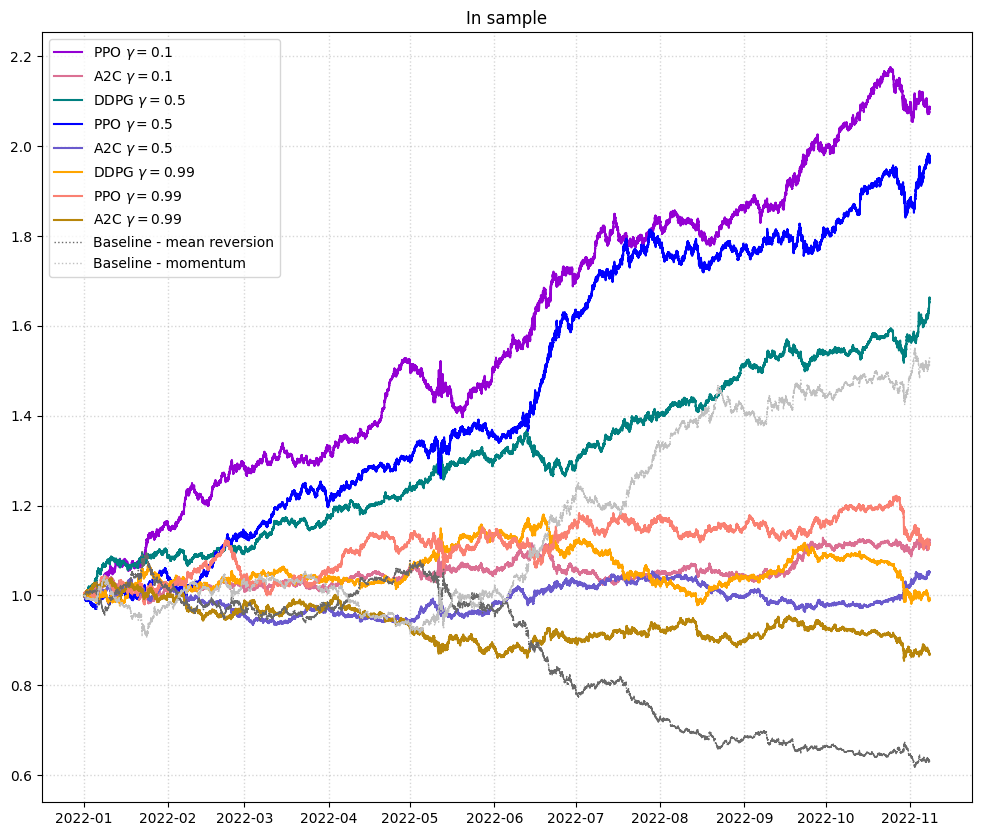

In [ ]:
fig,ax = plt.subplots(figsize=(12,10))

ax.plot(timeline[start_idx:val_idx+start_idx], 
        df_inSample['PPO_gamma=0.1']/10000, label='PPO $\\gamma=0.1$', color='darkviolet')
ax.plot(timeline[start_idx:val_idx+start_idx], 
        df_inSample['A2C_gamma=0.1']/10000, label='A2C $\\gamma=0.1$', color='palevioletred')
ax.plot(timeline[start_idx:val_idx+start_idx], 
        df_inSample['DDPG_gamma=0.5']/10000, label='DDPG $\\gamma=0.5$', color='teal')
ax.plot(timeline[start_idx:val_idx+start_idx], 
        df_inSample['PPO_gamma=0.5']/10000, label='PPO $\\gamma=0.5$', color='blue')
ax.plot(timeline[start_idx:val_idx+start_idx], 
        df_inSample['A2C_gamma=0.5']/10000, label='A2C $\\gamma=0.5$', color='slateblue')
ax.plot(timeline[start_idx:val_idx+start_idx], 
        df_inSample['DDPG_gamma=0.99']/10000, label='DDPG $\\gamma=0.99$', color='orange')
ax.plot(timeline[start_idx:val_idx+start_idx], 
        df_inSample['PPO_gamma=0.99']/10000, label='PPO $\\gamma=0.99$', color='salmon')
ax.plot(timeline[start_idx:val_idx+start_idx], 
        df_inSample['A2C_gamma=0.99']/10000, label='A2C $\\gamma=0.99$', color='darkgoldenrod')
ax.plot(timeline[start_idx:val_idx+start_idx], 
        mc_port_value[start_idx:val_idx+start_idx] / mc_port_value[start_idx], 
        label='Baseline - mean reversion', color='dimgrey', linestyle='dotted', linewidth=1)
ax.plot(timeline[start_idx:val_idx+start_idx], 
        mm_port_value[start_idx:val_idx+start_idx] / mm_port_value[start_idx], 
        label='Baseline - momentum', color='silver', linestyle='dotted', linewidth=1)
ax.set_title('In sample')
ax.grid(alpha=0.5, linestyle='dotted', linewidth=1)
ax.legend();

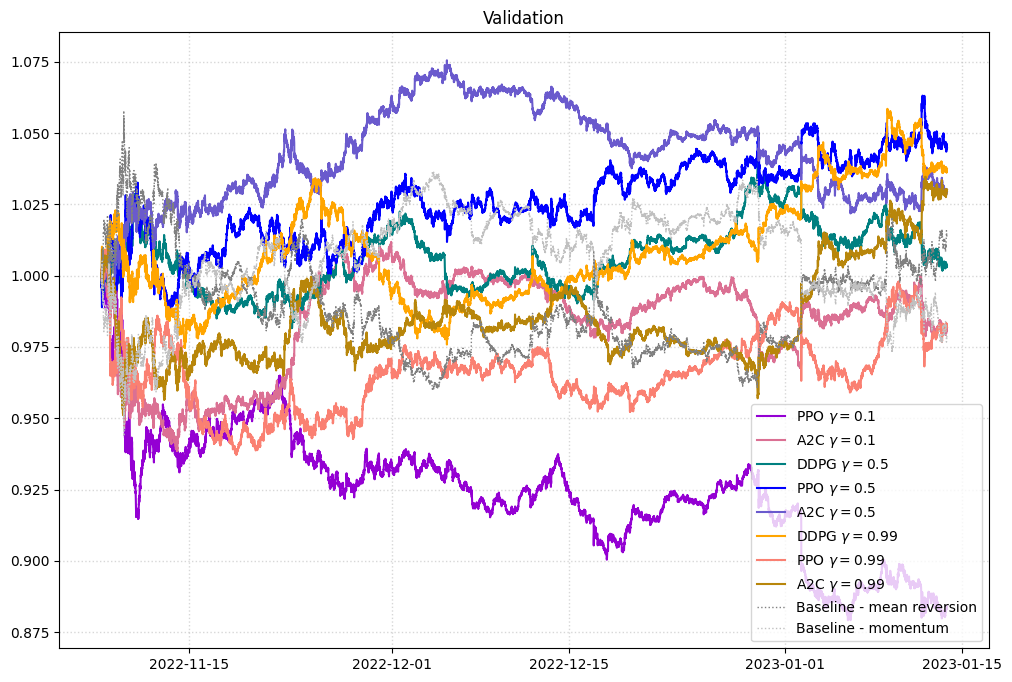

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))

ax.plot(timeline[val_idx+start_idx:test_idx+start_idx], 
        df_val['PPO_gamma=0.1']/10000, label='PPO $\\gamma=0.1$', color='darkviolet')
ax.plot(timeline[val_idx+start_idx:test_idx+start_idx], 
        df_val['A2C_gamma=0.1']/10000, label='A2C $\\gamma=0.1$', color='palevioletred')
ax.plot(timeline[val_idx+start_idx:test_idx+start_idx], 
        df_val['DDPG_gamma=0.5']/10000, label='DDPG $\\gamma=0.5$', color='teal')
ax.plot(timeline[val_idx+start_idx:test_idx+start_idx], 
        df_val['PPO_gamma=0.5']/10000, label='PPO $\\gamma=0.5$', color='blue')
ax.plot(timeline[val_idx+start_idx:test_idx+start_idx], 
        df_val['A2C_gamma=0.5']/10000, label='A2C $\\gamma=0.5$', color='slateblue')
ax.plot(timeline[val_idx+start_idx:test_idx+start_idx], 
        df_val['DDPG_gamma=0.99']/10000, label='DDPG $\\gamma=0.99$', color='orange')
ax.plot(timeline[val_idx+start_idx:test_idx+start_idx], 
        df_val['PPO_gamma=0.99']/10000, label='PPO $\\gamma=0.99$', color='salmon')
ax.plot(timeline[val_idx+start_idx:test_idx+start_idx], 
        df_val['A2C_gamma=0.99']/10000, label='A2C $\\gamma=0.99$', color='darkgoldenrod')
ax.plot(timeline[val_idx+start_idx:test_idx+start_idx], 
        mc_port_value[val_idx+start_idx:test_idx+start_idx] / mc_port_value[val_idx+start_idx], 
        label='Baseline - mean reversion', color='grey', linestyle='dotted', linewidth=1)
ax.plot(timeline[val_idx+start_idx:test_idx+start_idx], 
        mm_port_value[val_idx+start_idx:test_idx+start_idx] / mm_port_value[val_idx+start_idx], 
        label='Baseline - momentum', color='silver', linestyle='dotted', linewidth=1)
ax.set_title('Validation')
ax.grid(alpha=0.5, linestyle='dotted', linewidth=1)
ax.legend();

In [ ]:
df_inSample.to_csv(result_dir+'inSample.csv', index=False)
df_val.to_csv(result_dir+'val.csv', index=False)

# Sharpe ratio

In [ ]:
def calc_sharpe(px):
    annualize = np.sqrt(365)
    h = 12*24
    ret = px[h:]/px[:-h] - 1
    ret = ret[::h]
    return (ret.mean() / ret.std()) * annualize


In [ ]:
pd.DataFrame({'Sharpe': [calc_sharpe(df_val[i].values) for i in df_val.columns[1:]]
            }, index = df_val.columns[1:])

,Sharpe
A2C_gamma=0.5,1.800916
PPO_gamma=0.5,2.296174
DDPG_gamma=0.5,0.466160
A2C_gamma=0.99,1.083272
PPO_gamma=0.99,-0.511002
DDPG_gamma=0.99,1.679002
A2C_gamma=0.1,-0.643586
PPO_gamma=0.1,-3.440667


# Test set

In [ ]:
ppo_model = PPO.load(model_dir + "PPO_05Gamma_v1")

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.
  warnings.warn(


In [ ]:
# out of sample performance
ls_test_gym = LongShortEnv(full_data=test_data, total_time=test_data.shape[0], mode='Val', rand_start_time=False)

obs = ls_test_gym.reset()
for i in range(test_data.shape[0]-1):
    action, _states = ppo_model.predict(obs)
    obs, rewards, dones, info = ls_test_gym.step(action)
test_port_size =ls_test_gym.save_asset_memory()
test_weights = ls_test_gym.save_action_memory()

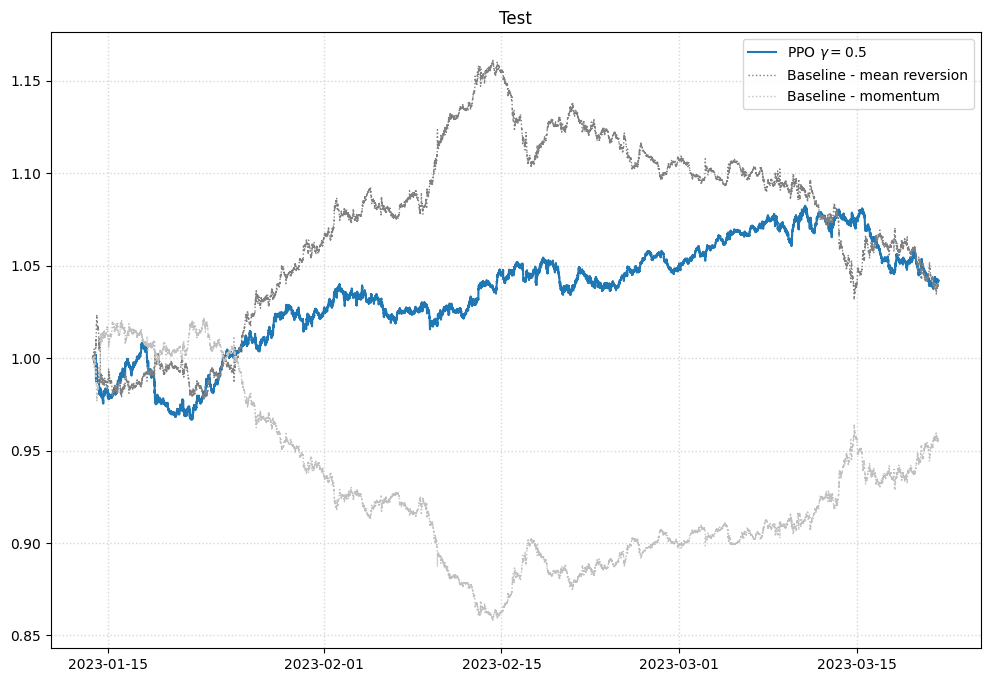

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))

ax.plot(timeline[test_idx+start_idx:], 
        np.array(test_port_size)/10000, label='PPO $\\gamma=0.5$')
ax.plot(timeline[test_idx+start_idx:], 
        mc_port_value[test_idx+start_idx:] / mc_port_value[test_idx+start_idx], 
        label='Baseline - mean reversion', color='grey', linestyle='dotted', linewidth=1)
ax.plot(timeline[test_idx+start_idx:], 
        mm_port_value[test_idx+start_idx:] / mm_port_value[test_idx+start_idx], 
        label='Baseline - momentum', color='silver', linestyle='dotted', linewidth=1)
ax.set_title('Test')
ax.grid(alpha=0.5, linestyle='dotted', linewidth=1)
ax.legend();

In [ ]:
print(f'Our strategy Sharpe: {calc_sharpe(np.array(test_port_size))}')
print(f'Baseline Mean Reversion Sharpe: {calc_sharpe(np.array(mc_port_value[test_idx+start_idx:]))}')
print(f'Baseline Momentum Sharpe: {calc_sharpe(np.array(mm_port_value[test_idx+start_idx:]))}')

Our strategy Sharpe: 1.6309963772077798
Baseline Mean Reversion Sharpe: 1.4567089316420148
Baseline Momentum Sharpe: -1.458284746567947


# For report

In [ ]:
df_inSample = pd.read_csv(result_dir+'inSample.csv')
df_val = pd.read_csv(result_dir+'val.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
(df_val.iloc[-1,1:] / df_val.iloc[0,1:] -1)*100

A2C_gamma=0.5      2.937646
PPO_gamma=0.5      4.464355
DDPG_gamma=0.5     0.324229
A2C_gamma=0.99     3.022676
PPO_gamma=0.99    -1.807314
DDPG_gamma=0.99    3.734443
dtype: object